In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [2]:
using ReactiveMP, KernelFunctions, Distributions, LinearAlgebra,GraphPPL, Rocket,Plots
using Flux, ForwardDiff, Zygote 
using StatsFuns: normcdf, normccdf, normlogcdf, normlogccdf, normlogpdf, normpdf, logsumexp
include("utils_gp2.jl")
pgfplotsx()
import ReactiveMP: renderCVI

┌ Warning: Package ReactiveMP does not have Zygote in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Zygote as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Zygote into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


Plots.PGFPlotsXBackend()

In [173]:
Random.seed!(3)
xmin, xmax = -6, 6  # Bounds of the data
N          = 100 # Number of samples
xtrain     = sort(rand(Uniform(xmin, xmax), N))
xtest      = collect(range(xmin - 0.1, xmax + 0.1; length=200));
kernelfunc =  Matern52Kernel()
meanfunc   = (x) -> 0.0;
grammatrix = kernelmatrix(kernelfunc,xtrain,xtrain) 
ytrain     = rand(MvNormal(zeros(length(xtrain)),grammatrix))
p          = normcdf.(ytrain)
ytrainbin  = map(rand,Bernoulli.(p));
ytrainbin = float(ytrainbin);

θ_init = 1. #our initial lengthscale
log_θ_init = log(θ_init)

0.0

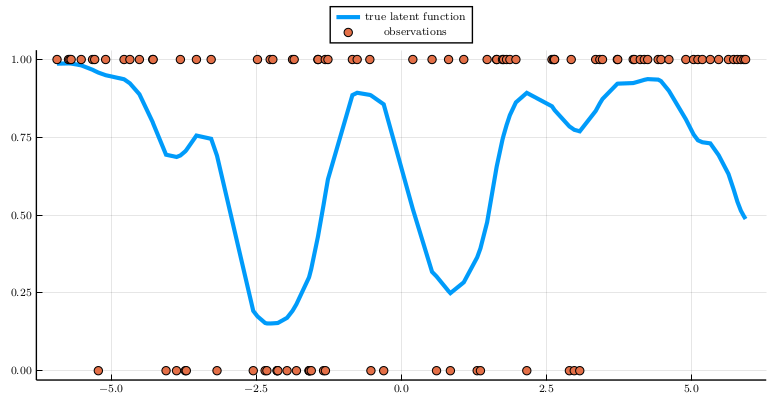

In [147]:
plot(xtrain,p,linewidth=3.0,label="true latent function")
scatter!(xtrain,ytrainbin,legend=:outertop,size=(800,400),label="observations")

In [174]:
@model function gpclassification(n,kernelfunc,meanfunc,train,test)
    y = datavar(Float64,n)
    x = randomprocess(test,train)
    η = randomvar() 

    η ~ NormalMeanVariance(log_θ_init, 2.)
    x ~ GaussianProcess(meanfunc,kernelfunc, η) where {meta = CVIApproximation(1000,50,ADAM(0.01)), 
    pipeline = RequireMarginal(θ)} 
    for i=1:n 
        y[i] ~ Probit(x) where {meta = (ProbitMeta(32), ProcessMeta(i,nothing,nothing,nothing))}
    end
    return x, η, y
end

In [175]:
@average_energy GaussianProcess (q_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any) = begin
    q_out.finitemarginal
    return -entropy(q_out.finitemarginal)
end

In [176]:
@rule Probit(:in, MomentMatching) (q_out::PointMass, m_in::GaussianProcess, meta::Tuple{ProbitMeta, ProcessMeta}) = begin 
    return @call_rule Probit(:in, MomentMatching) (m_out = q_out, m_in = m_in,meta=meta)
end

@rule Probit(:in, MomentMatching) (m_out::Union{PointMass, Bernoulli}, m_in::GaussianProcess,meta::Tuple{ProbitMeta,ProcessMeta}) =
    begin
    
        m_right, cov_right = mean_cov(m_in.finitemarginal)
        kernelf = m_in.kernelfunction
        meanf   = m_in.meanfunction
        test    = m_in.testinput
        train   = m_in.traininput
        mz, vz = predMVN_fast(m_in,test,[train[meta[2].index]],m_right) #change here 
        mz = mz[1]
        vz = vz[1]
        # extract parameters
        p = mean(m_out)
        @assert p >= zero(p) && p <= one(p) "The Probit node only accepts messages on its output with values between 0 and 1."

        # calculate auxiliary variables
        γ = mz / sqrt(1 + vz)

        # calculate moments of g
        if γ > 0 && p > 0.5
            log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogccdf(-γ)))
        elseif γ <= 0 && p > 0.5
            log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogcdf(γ)))
        elseif γ > 0 && p <= 0.5
            log_mom0_pz = logsumexp((log(1 - p) + normlogcdf(-γ), log(p) + normlogcdf(γ)))
        else
            log_mom0_pz = logsumexp((log(1 - p) + normlogccdf(γ), log(p) + normlogcdf(γ)))
        end
        tmp = log(vz) + normlogpdf(γ) - log(1 + vz) / 2 - log_mom0_pz
        mom1_pz = mz + (2 * p - 1) * exp(tmp)
        mom2_pz = vz + mz^2 + (2 * p - 1) * 2 * mz * exp(tmp) - (2p - 1) * γ * exp(log(vz) - log(1 + vz) / 2 + tmp)

        # calculate parameters of posterior
        mpz = mom1_pz
        vpz = mom2_pz - mom1_pz^2
        vpz = clamp(vpz, tiny, vz)# ensure variance of marginal is not larger than the variance of the cavity distribution.

        # calculate parameters of outgoing message
        wz_out = clamp(1 / vpz - 1 / vz, tiny, huge) # Ensure precision isn't too small or too large
        ξz_out = mpz / vpz - mz / vz

        # return message
        return NormalWeightedMeanPrecision(ξz_out, wz_out)
end

### rule just added 
@rule Probit(:in, MomentMatching) (q_out::PointMass, m_in::UnivariateNormalDistributionsFamily, meta::Tuple{ProbitMeta, ProcessMeta}) = begin 
    # extract parameters
    mz, vz = mean_cov(m_in)
    p = mean(q_out)
    @assert p >= zero(p) && p <= one(p) "The Probit node only accepts messages on its output with values between 0 and 1."

    # calculate auxiliary variables
    γ = mz / sqrt(1 + vz)

    # calculate moments of g
    if γ > 0 && p > 0.5
        log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogccdf(-γ)))
    elseif γ <= 0 && p > 0.5
        log_mom0_pz = logsumexp((log(1 - p), log(2 * p - 1) + normlogcdf(γ)))
    elseif γ > 0 && p <= 0.5
        log_mom0_pz = logsumexp((log(1 - p) + normlogcdf(-γ), log(p) + normlogcdf(γ)))
    else
        log_mom0_pz = logsumexp((log(1 - p) + normlogccdf(γ), log(p) + normlogcdf(γ)))
    end
    tmp = log(vz) + normlogpdf(γ) - log(1 + vz) / 2 - log_mom0_pz
    mom1_pz = mz + (2 * p - 1) * exp(tmp)
    mom2_pz = vz + mz^2 + (2 * p - 1) * 2 * mz * exp(tmp) - (2p - 1) * γ * exp(log(vz) - log(1 + vz) / 2 + tmp)

    # calculate parameters of posterior
    mpz = mom1_pz
    vpz = mom2_pz - mom1_pz^2
    vpz = clamp(vpz, tiny, vz)# ensure variance of marginal is not larger than the variance of the cavity distribution.

    # calculate parameters of outgoing message
    wz_out = clamp(1 / vpz - 1 / vz, tiny, huge) # Ensure precision isn't too small or too large
    ξz_out = mpz / vpz - mz / vz

    # return message
    return NormalWeightedMeanPrecision(ξz_out, wz_out)
end
###############

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::Any) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

function ReactiveMP.marginal_prod_fn(process::RandomProcess)
    test  = process.test_input
    train = process.train_input

    return messages -> begin 
        message_vector = map(ReactiveMP.as_message, messages)
        length(message_vector)
        process_message = getdata(message_vector[1])
        meanf = process_message.meanfunction
        kernelf = process_message.kernelfunction
        likelihood_messages = message_vector[2:end]
        m_right,cov_right = make_multivariate_message(likelihood_messages)

        m, K = predMVN(kernelf,meanf,train,test,m_right,cov_right)
        Kff = kernelmatrix(kernelf, test, test)
        invKff = cholinv(Kff + K)
        return Marginal(GaussianProcess(meanf,kernelf,MvNormalMeanCovariance(m,K),test,train,invKff),false,false)
    
    end
end

# function ReactiveMP.messages_prod_fn(process::RandomProcess)
#     return ReactiveMP.marginal_prod_fn(process)
# end
function ReactiveMP.messages_prod_fn(process::RandomProcess)
    return messages -> begin
        marginal = Rocket.getrecent(process.marginal.subject)
        if marginal == nothing
            #@show "here"
            return Message(NormalMeanVariance(0.0,0.01),false,false) #this is not a gaussian process 
        else
            #@show "here2"
            marginal = ReactiveMP.getdata(Rocket.getrecent(process.marginal.subject)) #this is a gaussian process 
            return Message(marginal,false,false)
        end
        
    end
end


In [177]:
#missing rule 
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::GammaShapeRate, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::PointMass, ) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::PointMass, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalMeanVariance, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:θ, Marginalisation) (q_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, 
        q_θ::UnivariateGaussianDistributionsFamily, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    #collect entities in meta
    n_iter = meta.num_iterations; 
    num_sample = meta.n_samples ;
    optimizer = meta.opt;
    RNG = meta.rng 
    #collect information from gaussian process q_out 
    test = q_out.testinput 
    meanf = q_meanfunc.point
    kernfunc(x) = with_lengthscale(q_kernelfunc.point, exp(x))
    y, Σ = mean_cov(q_out.finitemarginal)

    # do CVI 
    msg_in = q_θ
    λ_init = naturalparams(msg_in)
    #use "inv" instead of "cholinv"
    logp_nc(x) = -1/2 * (y - meanf.(test))' * inv(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test))) * (y- meanf.(test)) - 1/2 * logdet(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test)))
    λ = renderCVI(logp_nc, n_iter, optimizer, RNG, λ_init, msg_in)
    return convert(NormalMeanVariance, λ)
end

@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalWeightedMeanPrecision, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(q_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end
## additional rule for GP node in classification
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass, m_θ::NormalMeanVariance, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    kernelfunc = with_lengthscale(q_kernelfunc.point, exp(mean(m_θ))) 
    return GaussianProcess(q_meanfunc.point,kernelfunc,nothing,nothing,nothing,nothing)
end

@rule GaussianProcess(:θ, Marginalisation) (m_out::NormalMeanVariance, q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalMeanVariance, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
    return q_θ
end

@rule GaussianProcess(:θ, Marginalisation) (m_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, q_θ::NormalWeightedMeanPrecision, meta::CVIApproximation{Random._GLOBAL_RNG, ADAM}) = begin 
        #collect entities in meta
        n_iter = meta.num_iterations; 
        num_sample = meta.n_samples ;
        optimizer = meta.opt;
        RNG = meta.rng 
        #collect information from gaussian process q_out 
        test = m_out.testinput 
        meanf = q_meanfunc.point
        kernfunc(x) = with_lengthscale(q_kernelfunc.point, exp(x))
        y, Σ = mean_cov(m_out.finitemarginal)
    
        # do CVI 
        msg_in = q_θ
        λ_init = naturalparams(msg_in)
        #use "inv" instead of "cholinv"
        logp_nc(x) = -1/2 * (y - meanf.(test))' * inv(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test))) * (y- meanf.(test)) - 1/2 * logdet(kernelmatrix(kernfunc(x),test,test) + Diagonal(Σ) + 1e-8*diageye(length(test)))
        λ = renderCVI(logp_nc, n_iter, optimizer, RNG, λ_init, msg_in)
        return convert(NormalMeanVariance, λ)
end

In [178]:
nits = 10

iresult = inference(
    model = Model(gpclassification, N, kernelfunc, meanfunc, xtrain,xtest),
    iterations = nits,  
    initmarginals = (η = NormalMeanVariance(log_θ_init, 2.),),
    data  = (y = ytrainbin,),
    options = model_options(limit_stack_depth = 500)
    # showprogress= true,
    # free_energy = true   
)

Inference results:
-----------------------------------------
η = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=0.0...
x = GaussianProcess[GaussianProcess(var"#401#402"(), Matern 5/2 Kernel (metric = Dis...


In [179]:
exp.(mean.(iresult.posteriors[:η]))

10-element Vector{Float64}:
 1.0
 1.1924380586109264
 1.2336780599096013
 1.2758802896196157
 1.30064089979957
 1.3169179466786989
 1.3284329307090716
 1.3370086696883539
 1.3436430449993768
 1.3489281913108118

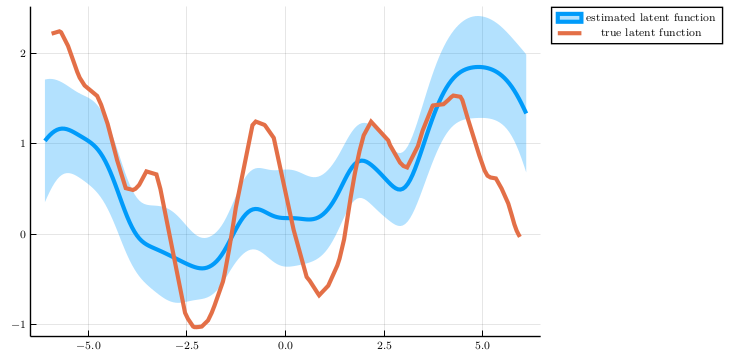

In [180]:
# visualize
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal), ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3,fillalpha=0.3,label="estimated latent function")
plot!(xtrain,ytrain,linewidth=3.0,label="true latent function")

In [47]:
function class_probabilities(gp)
    marginal = gp.finitemarginal
    m = mean(marginal)
    s =  sqrt.(1 .+ diag(cov(iresult.posteriors[:x][end].finitemarginal)))
    return normcdf.( m ./ s)
    
end

function class_predict(gp)
    
    return map(rand,Bernoulli.(class_probabilities(gp)))
end

class_predict (generic function with 1 method)

In [181]:
class_probs = class_probabilities(iresult.posteriors[:x][end]);
class_dist  = Bernoulli.(class_probs);
predicted_class = class_predict(iresult.posteriors[:x][end]);

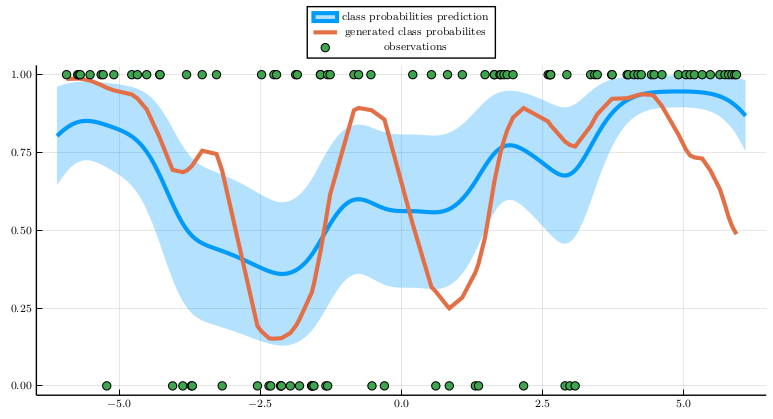

In [182]:
plot(xtest,mean.(class_dist),ribbon=(var.(class_dist)),fillalpha=0.3,linewidth=3.0, label="class probabilities prediction")
plot!(xtrain,p,linewidth=3.0,label="generated class probabilites")
scatter!(xtrain,ytrainbin,legend=:outertop,size=(800,400),label="observations")